In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import uszipcode
from uszipcode import SearchEngine
import seaborn as sns

In [2]:
data_path = '/Users/ameliabaum/Desktop/Amelia/Berkeley Fall 2019/CY PLAN 257/Final Project/data/'
notebooks_path = '/Users/ameliabaum/Desktop/Amelia/Berkeley Fall 2019/CY PLAN 257/Final Project/notebooks/'

## Load in test data. 
Filtered by valid zip codes and marked as being in bay or in la

In [5]:
bay_la_data = pd.read_csv(data_path+"raw_la_bay.csv") #344811 rows
bay_la_data.head()

,Unnamed: 0,HHPER,RELAT,GEND,AGE,HISP,RACE1,HHPERPLA,MODE,ARR_HR,...,PERNO,PLANO,APURP,STIME,ETIME,TSERIES_NUM,is_zip,is_bay,is_la,ORIGIN_ZIP
0,0,10319851,1,1,74,2,1.0,103198511,NaN,3,...,1,1,1,03:00,07:00,1,True,True,False,94591.0
1,1,10319851,1,1,74,2,1.0,103198511,NaN,3,...,1,1,2,07:00,08:10,2,True,True,False,94591.0
2,2,10319851,1,1,74,2,1.0,103198511,NaN,3,...,1,1,1,08:10,08:40,3,True,True,False,94510.0
3,3,10319851,1,1,74,2,1.0,103198512,6.0,9,...,1,2,37,09:02,12:48,1,True,True,False,94591.0
4,4,10319851,1,1,74,2,1.0,103198513,6.0,13,...,1,3,2,13:13,13:38,1,True,True,False,94591.0


In [71]:
la_data = test_data[test_data["is_la"] == True]
bay_data = test_data[test_data["is_bay"] == True]
len(la_data)

1113

In [36]:
intervals = {}
for i in range(0,24):  
    if (i <=9):
        left_time = '0{0}:00'.format(i)
        right_time = '0{0}:59'.format(i)            
    else:
        left_time = '{0}:00'.format(i)
        right_time = '{0}:59'.format(i)
    intervals[i] = pd.Interval(left=left_time, right=right_time, closed="both")


In [37]:
intervals[3]

Interval('03:00', '03:59', closed='both')

In [38]:
# "08:12" in intervals[8]
# "08:25" in intervals[8]
"03:00" in intervals[3]

True

In [20]:
# la_data["STIME"]

14        03:00
15        08:12
16        08:25
17        08:30
18        12:17
19        12:35
20        12:45
29        05:00
30        05:00
31        16:00
52        03:00
53        03:00
54        03:00
55        13:45
56        14:30
57        14:43
58        17:30
59        19:30
60        06:15
61        10:30
62        15:00
84        03:00
85        03:00
86        08:01
87        12:20
88        14:41
89        15:46
90        17:01
99        03:00
100       09:00
          ...  
337568    17:03
337569    17:28
337570    18:35
337571    19:00
337628    03:00
337629    07:50
337630    11:30
337631    16:10
337632    17:00
337633    19:15
337634    03:00
337635    07:00
337636    12:00
337637    18:20
337677    03:00
337678    11:20
337679    11:40
337680    13:30
337681    14:00
337682    14:55
337683    17:30
337684    19:05
338286    03:00
338287    11:00
338288    18:00
338289    03:00
338290    11:00
338291    18:00
338978    11:25
338979    20:20
Name: STIME, Length: 189

In [28]:
pd.Datetime(la_data.loc[14,"STIME"])
# in intervals[3]
# intervals[3]

AttributeError: module 'pandas' has no attribute 'Datetime'

In [9]:
def get_transit_byhr(df):
    walk = 1
    bike_etc = [2,3,4,8] #Bike/scooter/mobility scooter/wheelchair
    local_bus = [15,16,17,18,19,21,11]
    inter_rail = [22,23,24,25,12]
    intra_rail = [26,27]
    other = [13,29] #plane,ferry
    
    hrs = []
    transit_trip = df["MODE"].isin(inter_rail) | df["MODE"].isin(intra_rail) | df["MODE"].isin(local_bus)
    for i in range(0,24):
        hr_transit = len(df[(df["STIME"].apply(lambda x: x in intervals[i])) & transit_trip])
        hrs.append(hr_transit)
        

    return hrs

In [10]:
def get_autobyhr(df):
    '''categorized by arrival time'''   
    auto_etc = [5,6,7,10] #Car/taxi/TNC
    taxi = [9]

    auto_trip = df["MODE"].isin(auto_etc) | df["MODE"].isin(taxi) 

    hrs = []
    for i in range(0,24):
        hr_auto = len(df[(df["STIME"].apply(lambda x: x in intervals[i])) & auto_trip])
        hrs.append(hr_auto)
        

    return hrs

In [11]:
def get_purposebyhr(df):
    '''categorized by arrival time'''
    hrs = []
    
    school = [5,17,18,19,20]
    work = [6,9,10,16,12,11,25]
    errands = [26, 24, 29]
    discretionary = [37,36,34,35,33,14]
    shopping = [27,28]
    home = [3,8]

    shopp_err = df["APURP"].isin(shopping) | df["APURP"].isin(errands)
    home_trip = df["APURP"].isin(home)
    sch_work_trip = df["APURP"].isin(school) | df["APURP"].isin(work)
    discret_trip = df["APURP"].isin(discretionary) 


    for i in range(0,24):
        hr_sch_work = len(df[(df["STIME"].apply(lambda x: x in intervals[i])) & sch_work_trip])
        hrs.append(hr_sch_work)

    for i in range(0,24):
        hr_shop = len(df[(df["STIME"].apply(lambda x: x in intervals[i])) & shopp_err])
        hrs.append(hr_shop)

    for i in range(0,24):
        hr_home = len(df[(df["STIME"].apply(lambda x: x in intervals[i])) & home_trip])
        hrs.append(hr_home)

    for i in range(0,24):
        hr_discret = len(df[(df["STIME"].apply(lambda x: x in intervals[i])) & discret_trip])
        hrs.append(hr_discret)
    

    return hrs

In [12]:

def get_features(df):
    '''The get features function as a whole will calculate inbound or outbound trips based on the 
    column that the groupby is called on. Using "ZIP" will count inbound trips and using "ORIGIN_ZIP"
    will cont outbound trips'''
    
    get_transit_byhr(df)
    get_autobyhr(df)
    get_purposebyhr(df)

    feats = pd.Series(np.concatenate([get_transit_byhr(df), get_autobyhr(df), get_purposebyhr(df)]))
    return feats


In [61]:
def get_labels():
    labels = []
    for i in range(0,24):
        labels.append(("transit_hr_{0}").format(i))
        labels.append(("auto_hr_{0}").format(i))
        labels.append(("sch_work_hr_{0}").format(i))
        labels.append(("discret_hr_{0}").format(i))
        labels.append(("shopping_hr_{0}").format(i))
        labels.append(("home_hr_{0}").format(i))



    
    return labels

This is working well. I can keep expanding this to add inbound/outbound, totals, and maybe active modes too. Want to
make the hour mode more concise by using the dictionary. Also make sure to filter by bay and LA and do it separately.

In [15]:
la_data = bay_la_data[bay_la_data["is_la"]==True] #189511
sample = la_data.sample(5000)

In [16]:
la_inb = sample.groupby("ZIP").apply(get_features)
la_inb.columns = get_labels()
la_inb.head()

KeyboardInterrupt: 

#### Draw some histograms
Do a small sample at a time to visualize, ultimately these visualizations will be of the averages of the clusters

In [83]:
for i in range(0,24):
    transit_labels = [col for col in la_inb.columns if "transit_hr_" in col]
#     purpose_labels = [col for col in la_inb.columns if "purpose_hr_" in col]
    auto_labels = [col for col in la_inb.columns if "auto_hr_" in col]


In [93]:
first = la_inb.iloc[1,:]

(array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

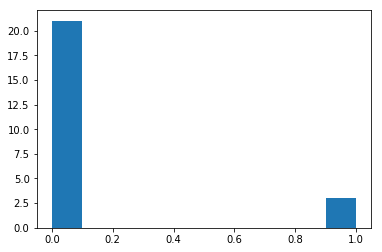

In [94]:
plt.hist(first[auto_labels])

In [74]:
bay_inb = bay_data.groupby("ZIP").apply(get_features)

bay_inb.columns = get_labels()
bay_inb.head()

,transit_hr_0,auto_hr_0,sch_work_hr_0,discret_hr_0,shopping_hr_0,home_hr_0,transit_hr_1,auto_hr_1,sch_work_hr_1,discret_hr_1,...,sch_work_hr_22,discret_hr_22,shopping_hr_22,home_hr_22,transit_hr_23,auto_hr_23,sch_work_hr_23,discret_hr_23,shopping_hr_23,home_hr_23
ZIP,,,,,,,,,,,,,,,,,,,,,
94010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94014,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
94015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0


/Users/ameliabaum/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


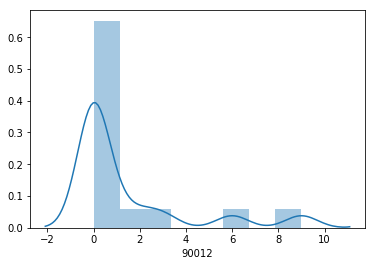

In [10]:
dist = sns.distplot((la_inb.T)[90012])